# Classification Modelling

In this notebook, we will go into the specifics of building a classification model with QSPRpred.
The main difference with regression is in the data preparation step, where we need to define the classes we want to predict.
If you are interested in regression modelling, please refer to the [quick start tutorial](../../quick_start.ipynb).

Let's first load our example dataset.

Data preparation is identical to regression, except that we need to define the classes we want to predict.
In this example we will split the bioactivity in active and inactive compounds, based on a threshold of 6.5.

You can see that the specification of the target property now includes the threshold `th` as well as the `task` `SINGLECLASS`.
(Note. multi-class classification is also possible, you can find an example [below](#Multi-class-classification).)
The QSPRDataset will now include the classfied target property ({name}_class) as well as the original target property.

In [2]:
import os

from IPython.display import display

from qsprpred.data import QSPRDataset

os.makedirs("../../tutorial_output/data", exist_ok=True)

dataset = QSPRDataset.fromTableFile(
    filename='../../tutorial_data/A2A_LIGANDS.tsv',
    store_dir="../../tutorial_output/data",
    name="ClassificationTutorialDataset",
    target_props=[{"name": "pchembl_value_Mean", "task": "SINGLECLASS", "th": [6.5]}],
    random_state=42
)

display(dataset.getDF())

/zfsdata/data/helle/01_MainProjects/03_QSPRPred/Scripts/QSPRpred/qsprpred/data/tables/mol.py:153: UserWarning: Existing data set found, but also found a data frame in store. Refusing to overwrite data. If you want to overwrite data in store, set overwrite=True.
  super().__init__(


,SMILES,pchembl_value_Mean,Year,QSPRID,pchembl_value_Mean_class,Split_IsTrain
QSPRID,,,,,,
ClassificationTutorialDataset_0000,Cc1cc(C)n(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n...,8.68,2008.0,ClassificationTutorialDataset_0000,True,True
ClassificationTutorialDataset_0001,Nc1c(C(=O)Nc2ccc([N+](=O)[O-])cc2)sc2nc3c(cc12...,4.82,2010.0,ClassificationTutorialDataset_0001,False,True
ClassificationTutorialDataset_0002,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,5.65,2009.0,ClassificationTutorialDataset_0002,False,True
ClassificationTutorialDataset_0003,CNC(=O)C12CC1C(n1cnc3c(NCc4cccc(Cl)c4)nc(C#CCC...,5.45,2009.0,ClassificationTutorialDataset_0003,False,True
ClassificationTutorialDataset_0004,CCCn1c(=O)c2c(nc3cc(OC)ccn32)n(CCCNC(=O)c2ccc(...,5.20,2019.0,ClassificationTutorialDataset_0004,False,True
...,...,...,...,...,...,...
ClassificationTutorialDataset_4077,CNc1ncc(C(=O)NCc2ccc(OC)cc2)c2nc(-c3ccco3)nn12,7.09,2018.0,ClassificationTutorialDataset_4077,True,False
ClassificationTutorialDataset_4078,Nc1nc(-c2ccco2)c2ncn(C(=O)NCCc3ccccc3)c2n1,8.22,2008.0,ClassificationTutorialDataset_4078,True,True
ClassificationTutorialDataset_4079,Nc1nc(CSc2nnc(N)s2)nc(Nc2ccc(F)cc2)n1,4.89,2010.0,ClassificationTutorialDataset_4079,False,False


Let's have a quick look at the distribution of the classes:

2495 active compounds and 1587 inactive compounds


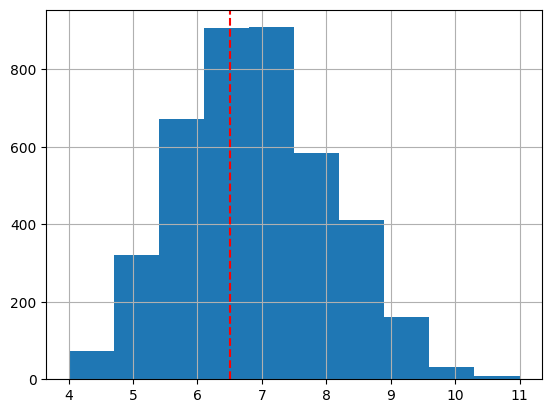

In [2]:

import matplotlib.pyplot as plt

# plot the distribution of the target property
dataset.getProperty("pchembl_value_Mean").hist()
plt.axvline(x=6.5, color='r', linestyle='--')

# print the number of active and inactive compounds
num_active = dataset.getProperty("pchembl_value_Mean_class").sum()
num_inactive = dataset.getProperty("pchembl_value_Mean_class").shape[0] - num_active
print(f"{num_active} active compounds and {num_inactive} inactive compounds")

Further data preparation is identical to regression.

In [3]:
from qsprpred.data import RandomSplit
from qsprpred.data.descriptors.sets import FingerprintSet
from qsprpred.data.descriptors.calculators import MoleculeDescriptorsCalculator

# define the feature calculator to calculate Morgan fingerprints
feature_calculator = MoleculeDescriptorsCalculator(
    desc_sets=[FingerprintSet(fingerprint_type="MorganFP", radius=3, nBits=2048)]
)

# Specifiy random split for creating the train (80%) and test set (20%)
rand_split = RandomSplit(test_fraction=0.2, dataset=dataset)

# calculate compound features and split dataset into train and test
dataset.prepareDataset(
    split=rand_split,
    feature_calculators=[feature_calculator],
)

print(f"Number of samples train set: {len(dataset.y)}")
print(f"Number of active samples train set: {dataset.y.sum()}")
print(f"Number of samples test set: {len(dataset.y_ind)}")
print(f"Number of active samples test set: {dataset.y_ind.sum()}")

dataset.save()

Number of samples train set: 3265
Number of active samples train set: pchembl_value_Mean_class    2002
dtype: int64
Number of samples test set: 817
Number of active samples test set: pchembl_value_Mean_class    493
dtype: int64


After data preparation, the model can be trained as usual.
We just need to make sure to use a model that supports classification.
In this example we will use a K-Nearest Neighbors model.

In [4]:
from qsprpred.models import SklearnModel
from sklearn.neighbors import KNeighborsClassifier
from qsprpred.models import CrossValAssessor, TestSetAssessor

os.makedirs("../../tutorial_output/models", exist_ok=True)

# This is an SKlearn model, so we will initialize it with the SklearnModel class
model = SklearnModel(
    base_dir='../../tutorial_output/models',
    data=dataset,
    alg=KNeighborsClassifier,
    name='ClassificationTutorialModel'
)

# We can now assess the model performance on the training set using cross validation
CrossValAssessor('roc_auc')(model)

# and on the test set
TestSetAssessor('roc_auc')(model)

# Finally, we need to fit the model on the complete dataset if we want to use it further
model.fitAttached()

# and save the model
model.save()

/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:767: Fu

'/zfsdata/data/helle/01_MainProjects/03_QSPRPred/Scripts/QSPRpred/tutorials/tutorial_output/models/ClassificationTutorialModel/ClassificationTutorialModel_meta.json'

To visualize the results, we will create a ROC curve for the cross validation results and the test set.

/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd

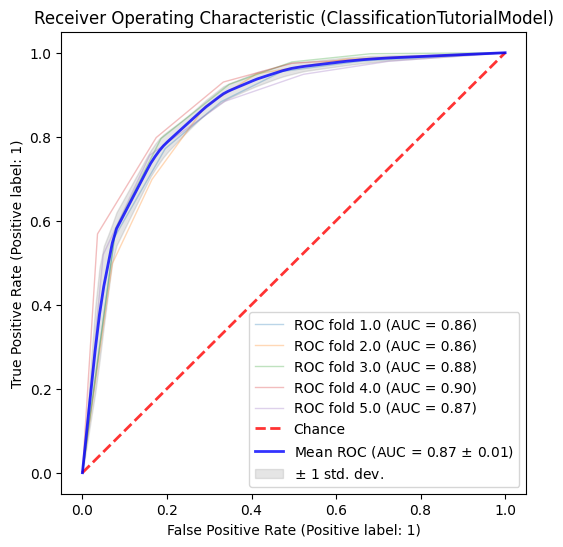

/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


<Figure size 640x480 with 0 Axes>

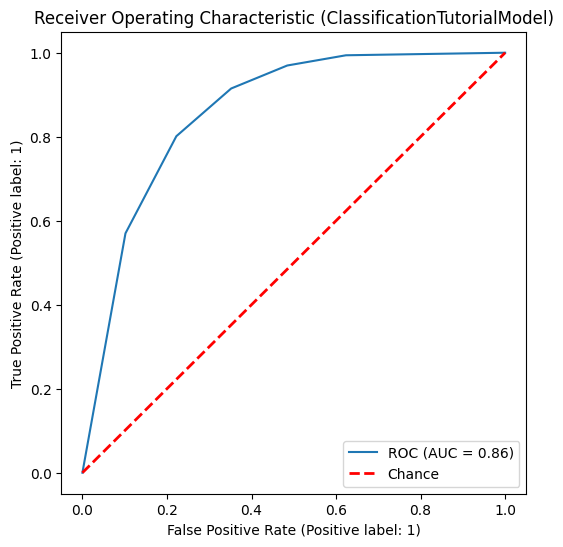

[<Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [5]:
from qsprpred.plotting.classification import ROCPlot

plot = ROCPlot([model])
plot.make(save=True, show=True, property_name="pchembl_value_Mean_class",
          validation="cv")
plot.make(save=True, show=True, property_name="pchembl_value_Mean_class",
          validation="ind")

We can also plot a number of metrics like the f1 score, matthews correlation coefficient, precision and recall and calibration error.

ClassificationTutorialModel


/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd

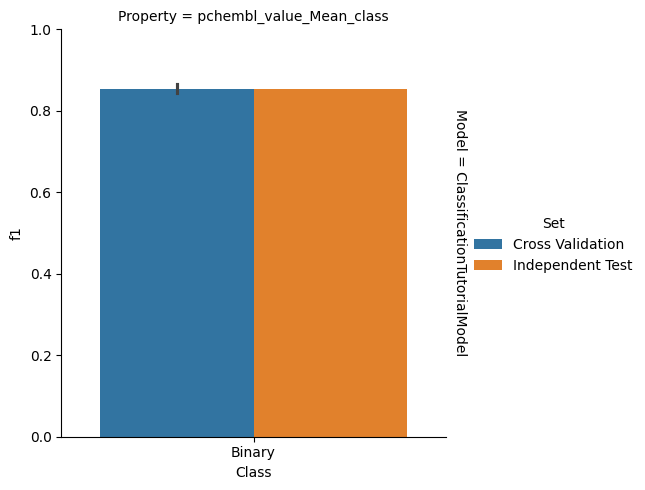

<Figure size 640x480 with 0 Axes>

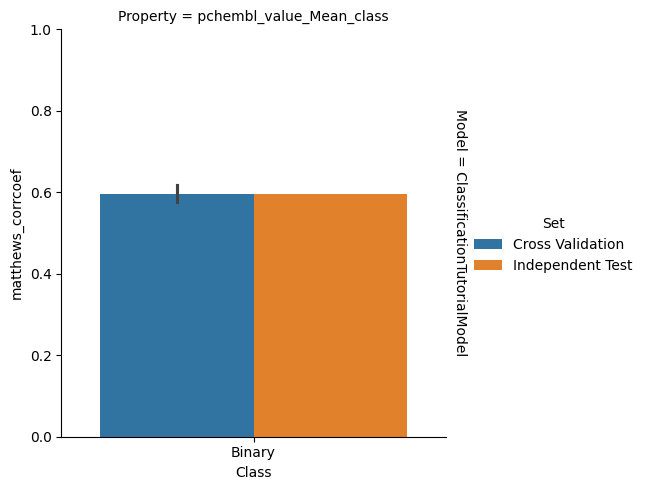

<Figure size 640x480 with 0 Axes>

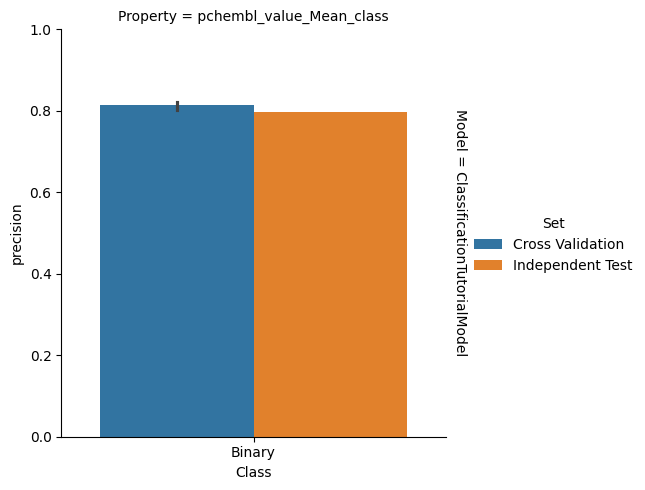

<Figure size 640x480 with 0 Axes>

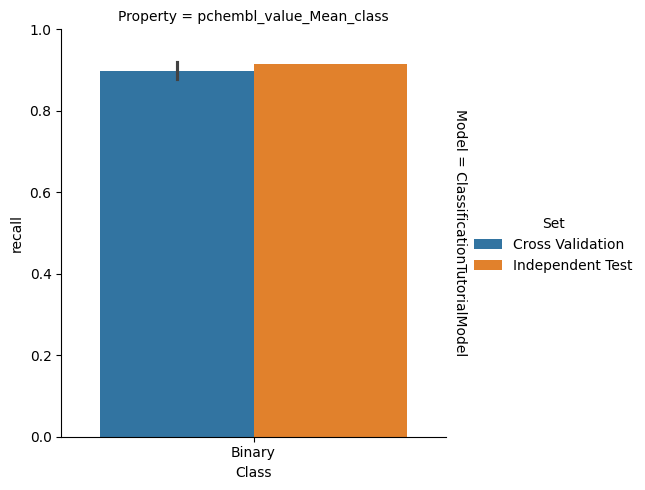

<Figure size 640x480 with 0 Axes>

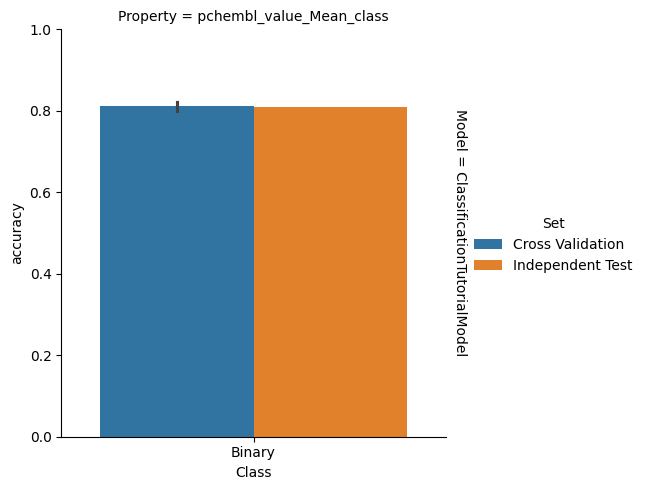

<Figure size 640x480 with 0 Axes>

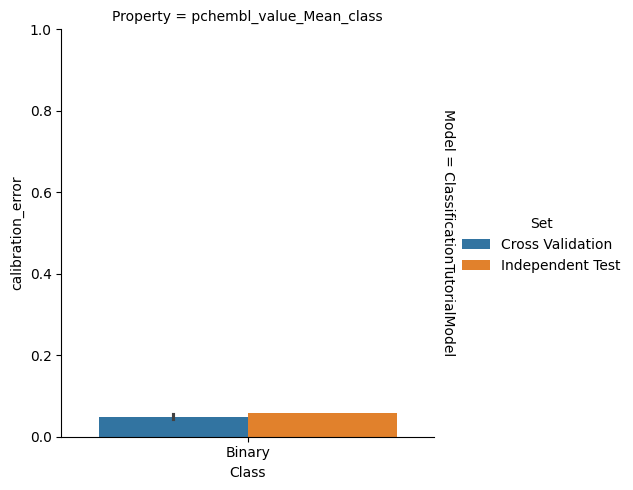

<Figure size 640x480 with 0 Axes>

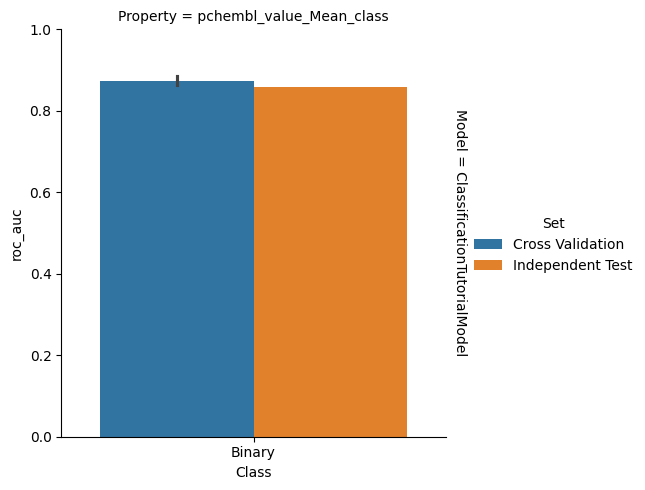

Metric roc_auc_ovr not in summary dataframe, skipping
Metric roc_auc_ovo not in summary dataframe, skipping


<Figure size 640x480 with 0 Axes>

In [7]:
from qsprpred.plotting.classification import MetricsPlot

plot = MetricsPlot([model])
figs, summary = plot.make(save=True, show=True)

We can also plot the confusion matrix (They are plotted for each fold in the cross validation and for the test set).

ClassificationTutorialModel


/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd

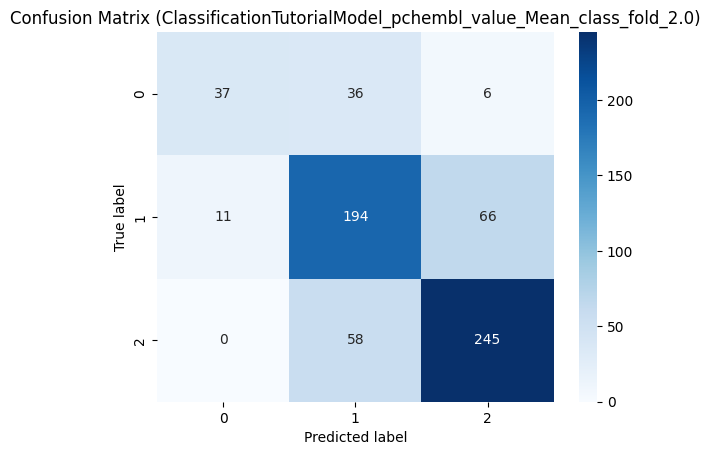

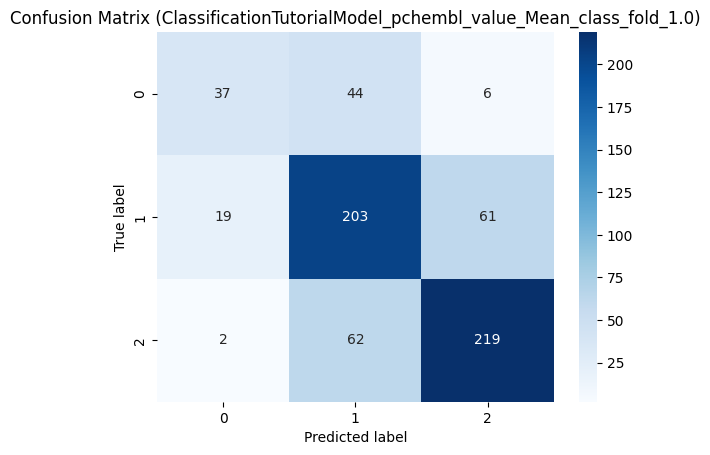

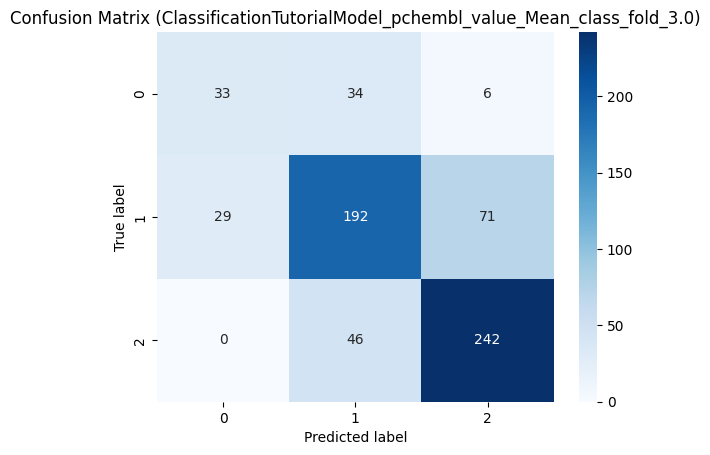

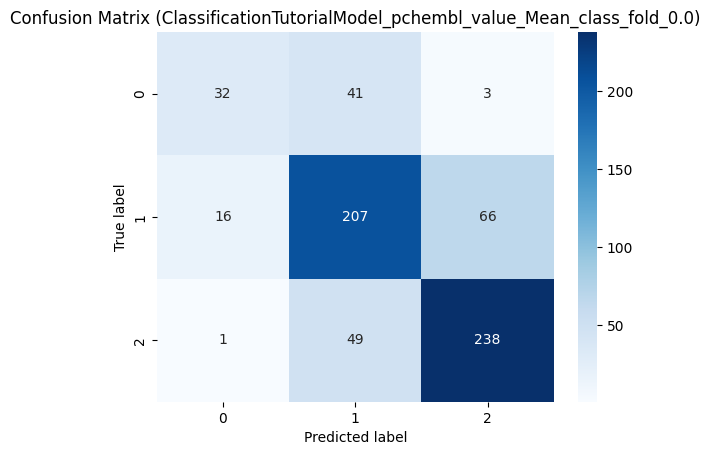

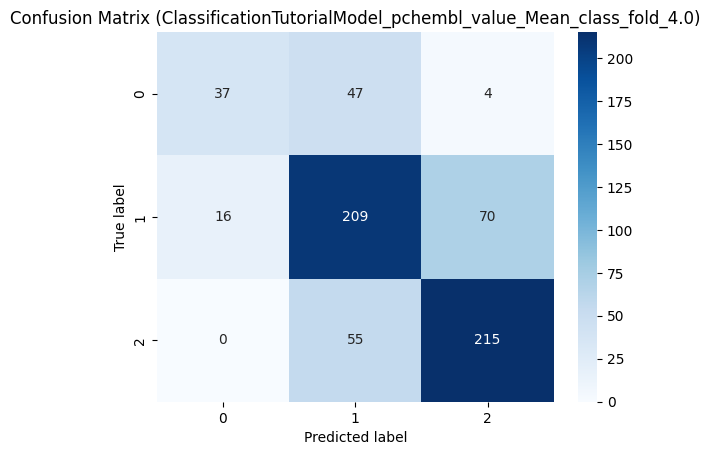

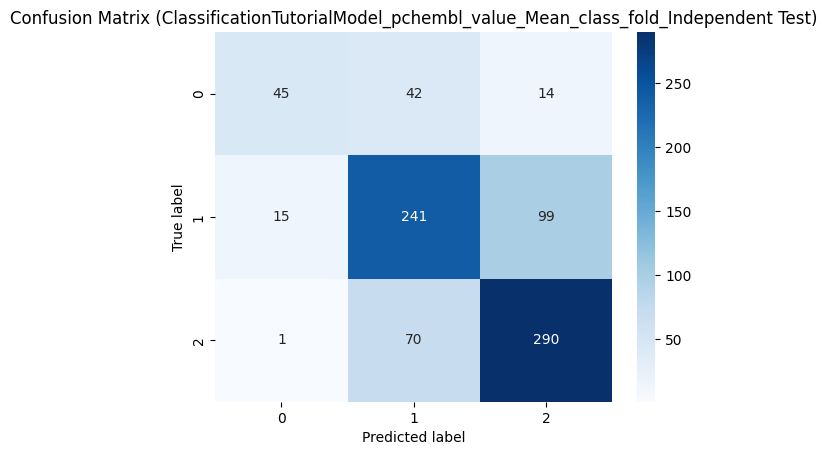

In [19]:
from qsprpred.plotting.classification import ConfusionMatrixPlot

plot = ConfusionMatrixPlot([model])
figs, summary = plot.make(save=True, show=True)

## Multi-class classification

Multi-class classification is also possible with QSPRpred.
In this case, we need to specify the `task` as `MULTICLASS` and provide a list of thresholds.
The threholds should include the lower and upper bound of each class.

So, let's load the data again and split the bioactivity into three classes:

In [7]:
from qsprpred.data import QSPRDataset
import os
from IPython.display import display

os.makedirs("../../tutorial_output/data", exist_ok=True)

dataset = QSPRDataset.fromTableFile(
    filename='../../tutorial_data/A2A_LIGANDS.tsv',
    store_dir="../../tutorial_output/data",
    name="ClassificationTutorialMultiClassDataset",
    target_props=[
        {"name": "pchembl_value_Mean", "task": "SINGLECLASS", "th": [0, 5.5, 7, 12]}],
    random_state=42
)

display(dataset.getDF())

/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


,SMILES,pchembl_value_Mean,Year,QSPRID,pchembl_value_Mean_class_intervals,pchembl_value_Mean_class
QSPRID,,,,,,
ClassificationTutorialMultiClassDataset_0000,Cc1nn(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n2)c(...,8.68,2008.0,ClassificationTutorialMultiClassDataset_0000,"(7.0, 12.0]",2
ClassificationTutorialMultiClassDataset_0001,Nc1c(C(=O)Nc2ccc([N+](=O)[O-])cc2)sc2c1cc1CCCC...,4.82,2010.0,ClassificationTutorialMultiClassDataset_0001,"(-0.001, 5.5]",0
ClassificationTutorialMultiClassDataset_0002,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,5.65,2009.0,ClassificationTutorialMultiClassDataset_0002,"(5.5, 7.0]",1
ClassificationTutorialMultiClassDataset_0003,CNC(=O)C12CC1C(n1cnc3c1nc(C#CCCCCC(=O)OC)nc3NC...,5.45,2009.0,ClassificationTutorialMultiClassDataset_0003,"(-0.001, 5.5]",0
ClassificationTutorialMultiClassDataset_0004,CCCn1c(=O)c2c(nc3cc(OC)ccn32)n(CCCNC(=O)c2ccc(...,5.20,2019.0,ClassificationTutorialMultiClassDataset_0004,"(-0.001, 5.5]",0
...,...,...,...,...,...,...
ClassificationTutorialMultiClassDataset_4077,CNc1ncc(C(=O)NCc2ccc(OC)cc2)c2nc(-c3ccco3)nn12,7.09,2018.0,ClassificationTutorialMultiClassDataset_4077,"(7.0, 12.0]",2
ClassificationTutorialMultiClassDataset_4078,Nc1nc(-c2ccco2)c2ncn(C(=O)NCCc3ccccc3)c2n1,8.22,2008.0,ClassificationTutorialMultiClassDataset_4078,"(7.0, 12.0]",2
ClassificationTutorialMultiClassDataset_4079,Nc1nc(Nc2ccc(F)cc2)nc(CSc2nnc(N)s2)n1,4.89,2010.0,ClassificationTutorialMultiClassDataset_4079,"(-0.001, 5.5]",0


Let's have a quick look at the distribution of the classes again:

1793 active compounds, 1785 intermediate and 504 inactive compounds


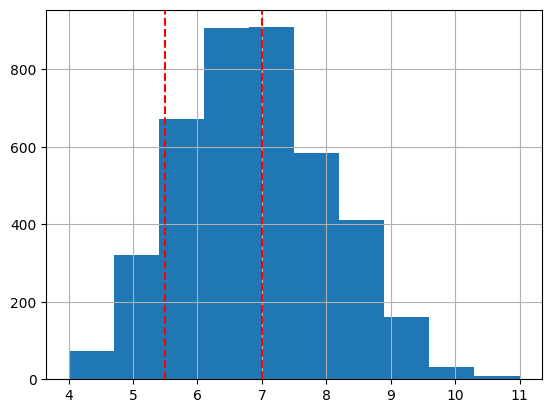

In [15]:

import matplotlib.pyplot as plt

# plot the distribution of the target property
dataset.getProperty("pchembl_value_Mean").hist()
plt.axvline(x=5.5, color='r', linestyle='--')
plt.axvline(x=7, color='r', linestyle='--')

# print the number of active and inactive compounds
num_inactive = dataset.getProperty("pchembl_value_Mean_class").value_counts()[0]
num_intermediate = dataset.getProperty("pchembl_value_Mean_class").value_counts()[1]
num_active = dataset.getProperty("pchembl_value_Mean_class").value_counts()[2]
print(
    f"{num_active} active compounds, {num_intermediate} intermediate and {num_inactive} inactive compounds")

Further data preparation and model training is identical to binary classification.

In [11]:
from qsprpred.data import RandomSplit
from qsprpred.data.descriptors.sets import FingerprintSet
from qsprpred.data.descriptors.calculators import MoleculeDescriptorsCalculator

# define the feature calculator to calculate Morgan fingerprints
feature_calculator = MoleculeDescriptorsCalculator(
    desc_sets=[FingerprintSet(fingerprint_type="MorganFP", radius=3, nBits=2048)]
)

# Specifiy random split for creating the train (80%) and test set (20%)
rand_split = RandomSplit(test_fraction=0.2, dataset=dataset)

# calculate compound features and split dataset into train and test
dataset.prepareDataset(
    split=rand_split,
    feature_calculators=[feature_calculator],
)

print(f"Number of samples train set: {len(dataset.y)}")
print(f"Number of inactive samples train set: {dataset.y.value_counts()[0]}")
print(f"Number of intermediate samples train set: {dataset.y.value_counts()[1]}")
print(f"Number of active samples train set: {dataset.y.value_counts()[2]}")
print(f"Number of samples test set: {len(dataset.y_ind)}")
print(f"Number of inactive samples test set: {dataset.y_ind.value_counts()[0]}")
print(f"Number of intermediate samples test set: {dataset.y_ind.value_counts()[1]}")
print(f"Number of active samples test set: {dataset.y_ind.value_counts()[2]}")

dataset.save()

Molecular descriptors already exist in ClassificationTutorialMultiClassDataset. Use `recalculate=True` to overwrite them.


Number of samples train set: 3265
Number of inactive samples train set: 403
Number of intermediate samples train set: 1430
Number of active samples train set: 1432
Number of samples test set: 817
Number of inactive samples test set: 101
Number of intermediate samples test set: 355
Number of active samples test set: 361


Make sure to use a model and a metric (here roc_auc_ovr) that supports multi-class classification.

In [17]:
from qsprpred.models.sklearn import SklearnModel
from sklearn.neighbors import KNeighborsClassifier
from qsprpred.models import CrossValAssessor, TestSetAssessor

os.makedirs("../../tutorial_output/models", exist_ok=True)

# This is an SKlearn model, so we will initialize it with the SklearnModel class
model = SklearnModel(
    base_dir='../../tutorial_output/models',
    data=dataset,
    alg=KNeighborsClassifier,
    name='ClassificationTutorialModel'
)

# We can now assess the model performance on the training set using cross validation
CrossValAssessor('roc_auc_ovr')(model)

# and on the test set
TestSetAssessor('roc_auc_ovr')(model)

# Finally, we need to fit the model on the complete dataset if we want to use it further
model.fitAttached()

# and save the model
model.save()

/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed

'/zfsdata/data/helle/01_MainProjects/03_QSPRPred/Scripts/QSPRpred/tutorials/tutorial_output/models/ClassificationTutorialModel/ClassificationTutorialModel_meta.json'

Plotting the ROC curve directly with QSPRpred is not possible for multi-class classification, but we can make the `MetricPlot` in the same way as for binary classification.
It will plot the metric for each class, as well as the average over all classes (macro average), the global average (micro average) and the weighted average (see [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) for details), for metrics that support this.

ClassificationTutorialModel


/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd

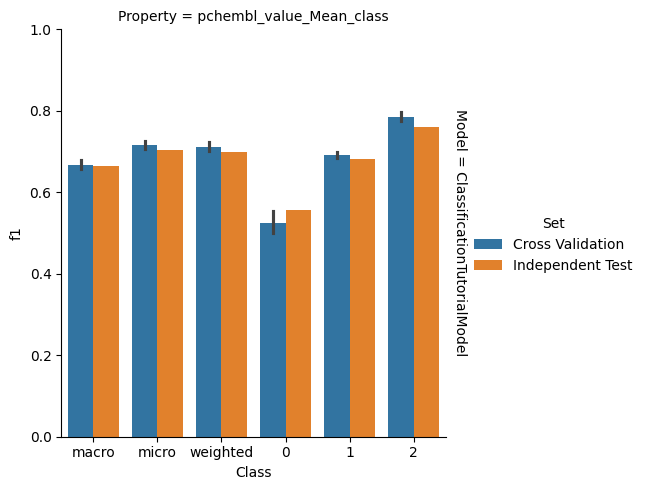

<Figure size 640x480 with 0 Axes>

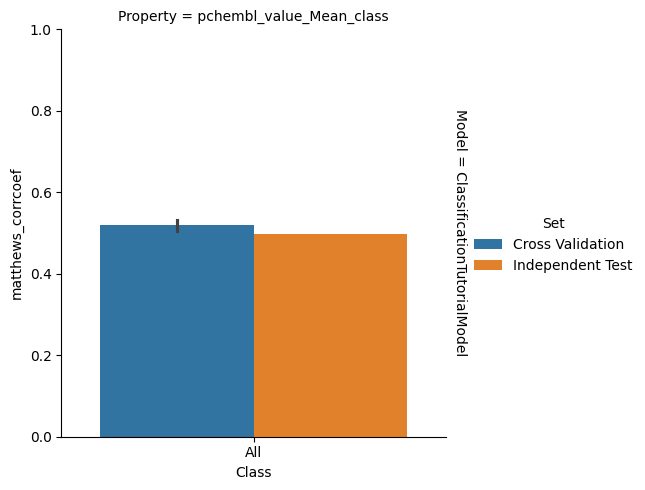

<Figure size 640x480 with 0 Axes>

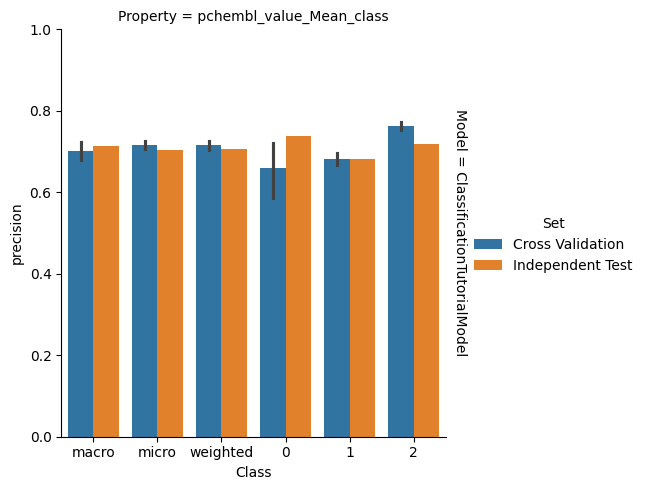

<Figure size 640x480 with 0 Axes>

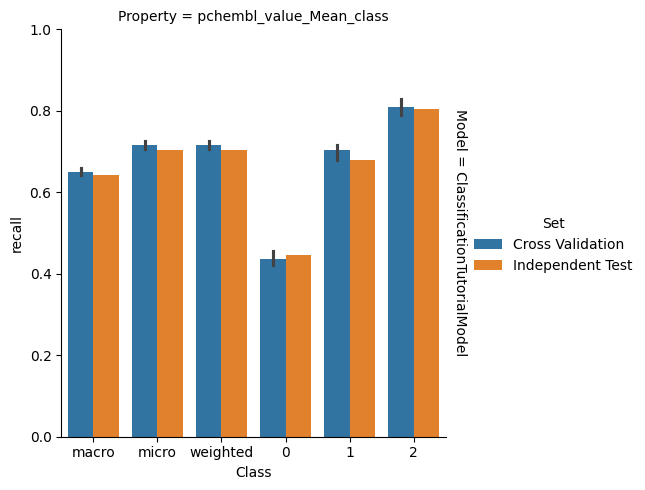

<Figure size 640x480 with 0 Axes>

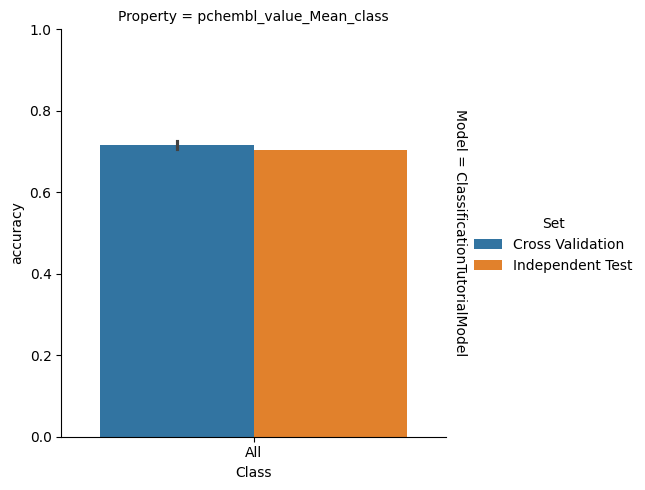

<Figure size 640x480 with 0 Axes>

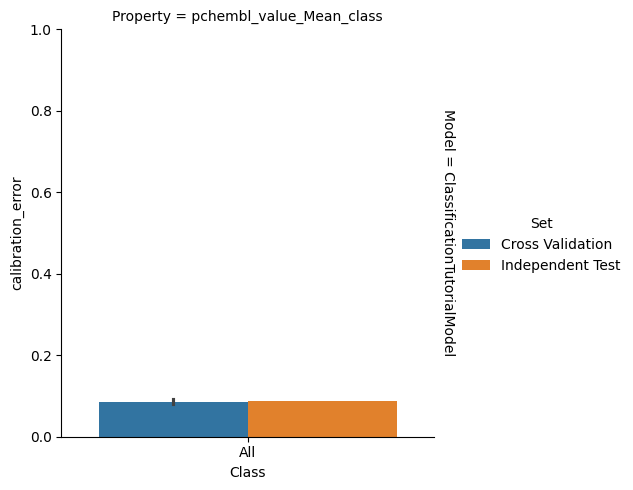

Metric roc_auc not in summary dataframe, skipping


<Figure size 640x480 with 0 Axes>

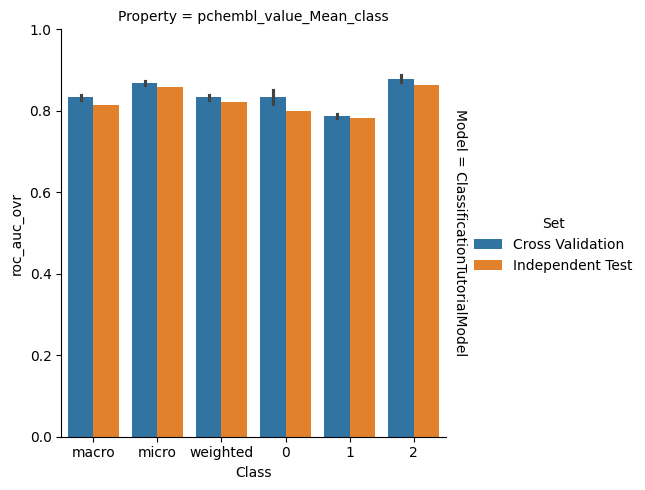

<Figure size 640x480 with 0 Axes>

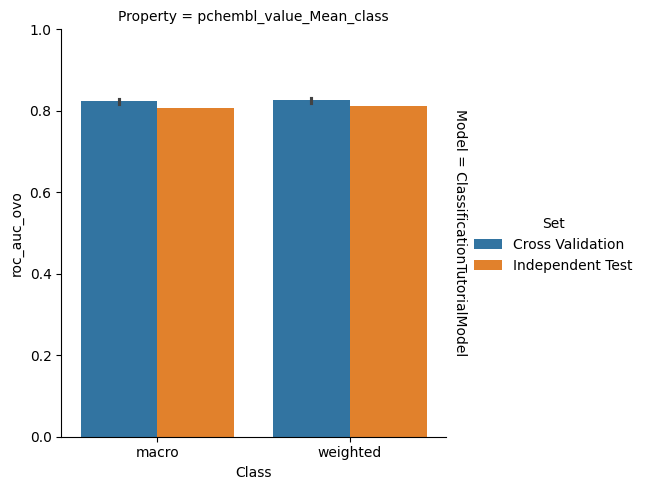

<Figure size 640x480 with 0 Axes>

In [18]:
from qsprpred.plotting.classification import MetricsPlot

plot = MetricsPlot([model])
figs, summary = plot.make(save=True, show=True)

We can also plot the confusion matrix (They are plotted for each fold in the cross validation and for the test set).

ClassificationTutorialModel


/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd

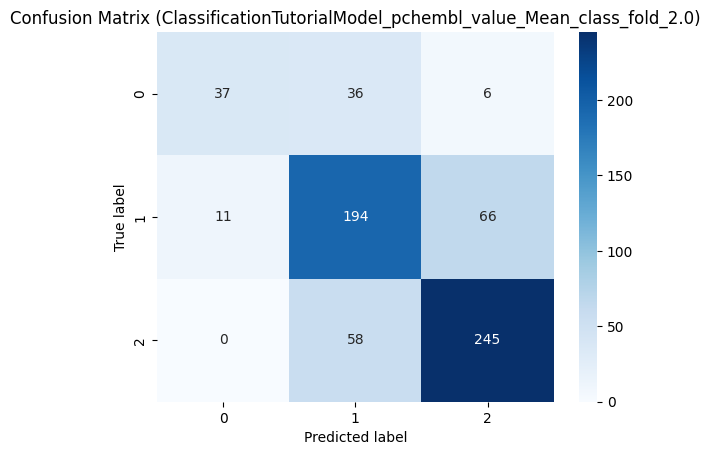

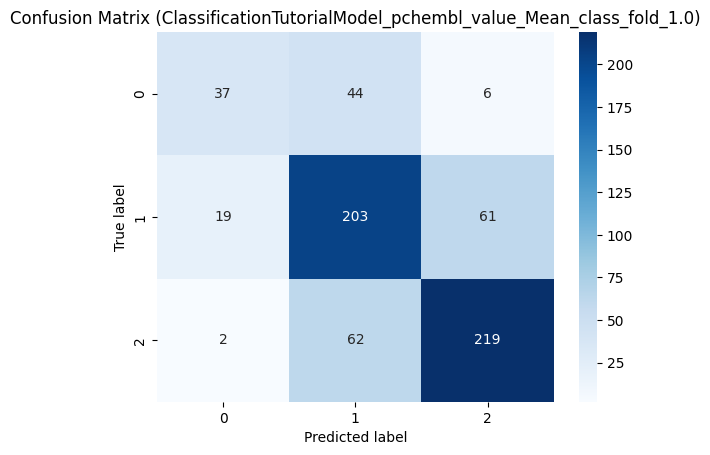

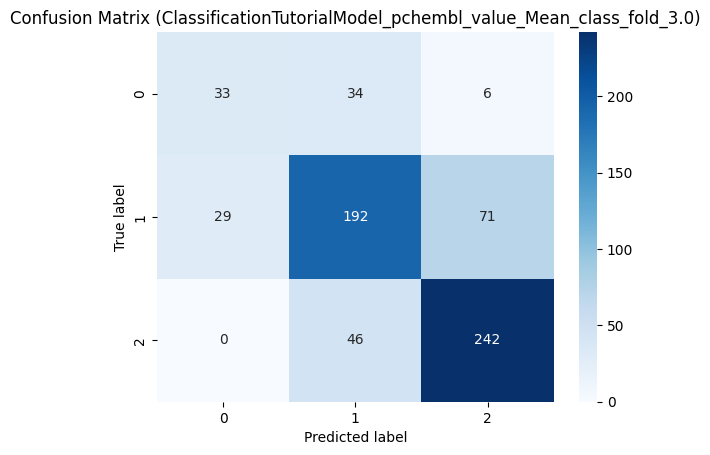

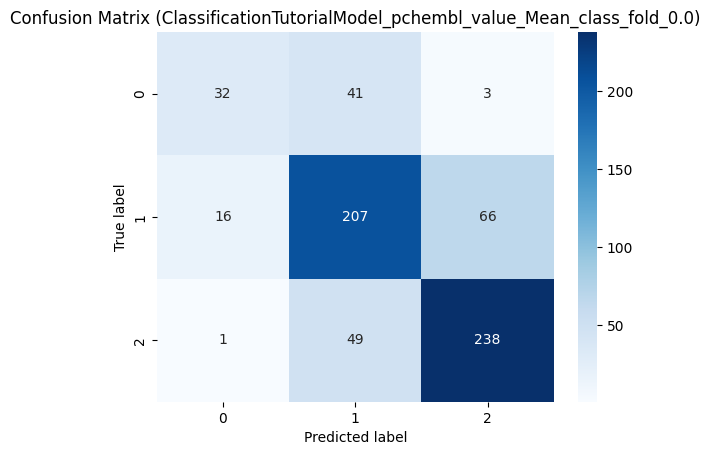

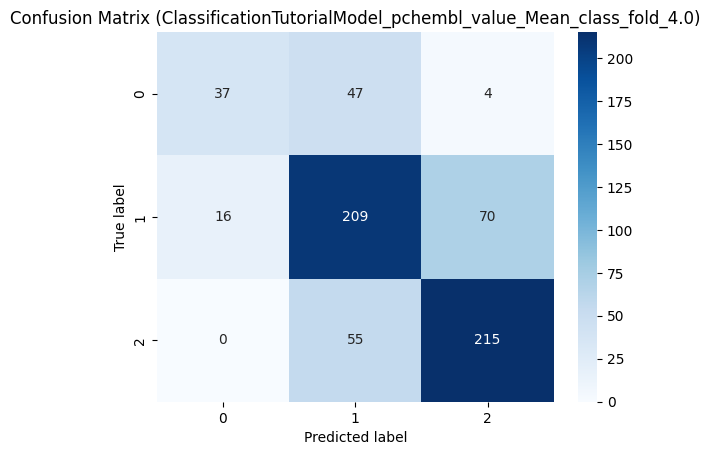

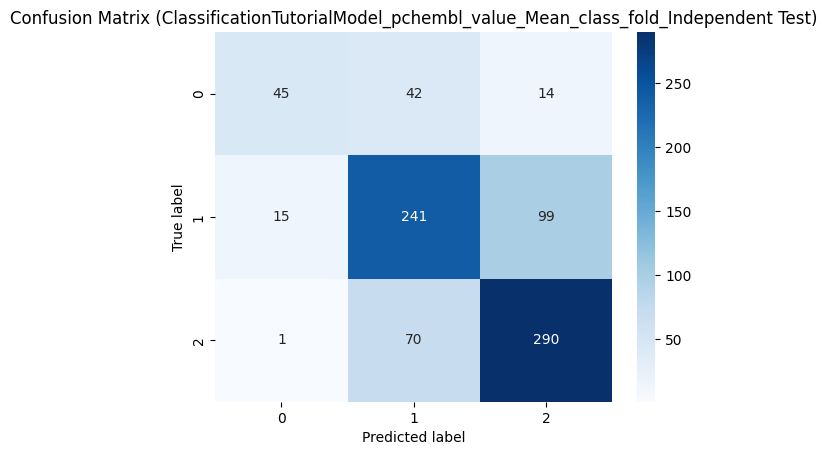

([<Figure size 640x480 with 2 Axes>,
  <Figure size 640x480 with 2 Axes>,
  <Figure size 640x480 with 2 Axes>,
  <Figure size 640x480 with 2 Axes>,
  <Figure size 640x480 with 2 Axes>,
  <Figure size 640x480 with 2 Axes>],
 {('ClassificationTutorialModel',
   'pchembl_value_Mean_class',
   2.0): array([[ 37,  36,   6],
         [ 11, 194,  66],
         [  0,  58, 245]]),
  ('ClassificationTutorialModel',
   'pchembl_value_Mean_class',
   1.0): array([[ 37,  44,   6],
         [ 19, 203,  61],
         [  2,  62, 219]]),
  ('ClassificationTutorialModel',
   'pchembl_value_Mean_class',
   3.0): array([[ 33,  34,   6],
         [ 29, 192,  71],
         [  0,  46, 242]]),
  ('ClassificationTutorialModel',
   'pchembl_value_Mean_class',
   0.0): array([[ 32,  41,   3],
         [ 16, 207,  66],
         [  1,  49, 238]]),
  ('ClassificationTutorialModel',
   'pchembl_value_Mean_class',
   4.0): array([[ 37,  47,   4],
         [ 16, 209,  70],
         [  0,  55, 215]]),
  ('Classificatio

In [22]:
from qsprpred.plotting.classification import ConfusionMatrixPlot

plot = ConfusionMatrixPlot([model])
plot.make(save=True, show=True)